# [`ml4gw`](https://github.com/ML4GW/ml4gw) Tutorial

This tutorial has two parts:
1. An overview of many of the features of `ml4gw`, with demonstrations
2. An example of training a model using these features

**Requirements:** This notebook requires a number of packages besides `ml4gw` to run completely.
Install with:

```bash
pip install "ml4gw>=0.7.6" "gwpy>=3.0" "h5py>=3.12" "torchmetrics>=1.6" "lightning>=2.4.0" "rich>=10.2.2,<14.0"

In [1]:
import torch
import matplotlib.pyplot as plt

plt.rcParams.update(
    {
        "text.usetex": False,
        # "font.family": "Computer Modern",
        "font.size": 16,
        "figure.dpi": 100,
    }
)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Uniform
from ml4gw.distributions import Sine, DeltaFunction, UniformComovingVolume
from ml4gw.waveforms import IMRPhenomD
from gwpy.timeseries import TimeSeries, TimeSeriesDict
from ml4gw.waveforms.generator import TimeDomainCBCWaveformGenerator
from ml4gw.waveforms.conversion import chirp_mass_and_mass_ratio_to_components
from ml4gw.gw import get_ifo_geometry, compute_observed_strain, reweight_snrs
from ml4gw.dataloading import Hdf5TimeSeriesDataset
from ml4gw.transforms import Whiten, SpectralDensity
from torchmetrics.classification import BinaryAUROC
from pathlib import Path
from tqdm import tqdm
import numpy as np
import random
import h5py
from sklearn.metrics import roc_curve, auc

device = "cuda" if torch.cuda.is_available() else "cpu"
data_dir = Path("./data")

/home/bhgupta/.conda/envs/mlgw/lib/python3.10/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
background_dir = data_dir / "background_data_1"
ifos = ["H1", "L1"]

waveform_duration = 60
sample_rate = 2048
f_min = 20
f_max = 1024
f_ref = 20

num_samples = int(waveform_duration * sample_rate)
num_freqs = num_samples // 2 + 1
frequencies = torch.linspace(0, sample_rate/2, num_freqs).to(device)
freq_mask = (frequencies >= f_min) & (frequencies < f_max)

param_dict = {
    "chirp_mass": Uniform(1.17, 2.2),
    "mass_ratio": Uniform(0.6, 1.0),
    "chi1": Uniform(-0.05, 0.05),
    "chi2": Uniform(-0.05, 0.05),
    "distance": UniformComovingVolume(10,500,distance_type='luminosity_distance'),
    "phic": DeltaFunction(0),
    "inclination": Sine(),
}

approximant = IMRPhenomD().to(device)
waveform_generator = TimeDomainCBCWaveformGenerator(
    approximant=approximant,
    sample_rate=sample_rate,
    f_min=f_min,
    duration=waveform_duration,
    right_pad=0.5,
    f_ref=f_ref,
).to(device)

tensors, vertices = get_ifo_geometry(*ifos)
tensors, vertices = tensors.to(device), vertices.to(device)

psd_length = 20
fduration = 2

whiten = Whiten(
    fduration=fduration, sample_rate=sample_rate, highpass=f_min
).to(device)

## Architectures

We've implemented a couple basic [neural network architectures](https://github.com/ML4GW/ml4gw/tree/main/ml4gw/nn) for out-of-the-box convenience. Today, we'll be using a 1D ResNet, which is mostly copied from PyTorch's implementation, but with a few key differences:
- Arbitrary kernel sizes
- `GroupNorm` as the default normalization layer, as training statistics in general won't match testing statistics
- Custom `GroupNorm` implementation which is faster than the standard PyTorch version at inference time

In [5]:
from ml4gw.nn.resnet import ResNet1D

architecture = ResNet1D(
    in_channels=2,  # H1 and L1 as input channels
    layers=[2, 2],  # Keep things small and do a ResNet10
    classes=1,  # Single scalar-valued output
    kernel_size=3,  # Size of convolutional kernels, not to be confused with data size
).to(device)

# And we can, e.g., pass the first element of our validation set
# with torch.no_grad():
#     print(architecture(whitened_injected[0][None]))

In [6]:
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)  
        self.relu = torch.nn.ReLU()                         
        self.fc2 = torch.nn.Linear(hidden_size, output_size) 

    def forward(self, x):
        x = self.fc1(x)  
        x = self.relu(x) 
        x = self.fc2(x)
        return x

## Example training setup

We'll now go through an example of putting many of these pieces together into a single model, implemented using th [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/) framework.

Begin by clearing the GPU:

In [7]:
import gc

gc.collect()
torch.cuda.empty_cache()
# torch.cuda.reset_peak_memory_stats()

In [8]:
from ml4gw import augmentations, distributions, gw, transforms, waveforms
from ml4gw.dataloading import ChunkedTimeSeriesDataset, Hdf5TimeSeriesDataset
from ml4gw.utils.slicing import sample_kernels
import torch
from lightning import pytorch as pl
import torchmetrics
from torchmetrics.classification import BinaryAUROC

from typing import Callable, Dict, List


class Ml4gwDetectionModel(pl.LightningModule):
    """
    Model with methods for generating waveforms and
    performing our preprocessing augmentations in
    real-time on the GPU. Also loads training background
    in chunks from disk, then samples batches from chunks.
    """

    def __init__(
        self,
        metric: torchmetrics.Metric,
        mode: str = 'multi',
        attention: bool = False,
        multimodal: bool = False,
        freq_series = False,
        architecture: torch.nn.Module = None,
        architecture_a: torch.nn.Module = None,
        architecture_b: torch.nn.Module = None,
        architecture_c: torch.nn.Module = None,
        architecture_d: torch.nn.Module = None,
        architecture_e: torch.nn.Module = None,
        architecture_f: torch.nn.Module = None,
        architecture_g: torch.nn.Module = None,
        architecture_h: torch.nn.Module = None,
        architecture_i: torch.nn.Module = None,
        ifos: List[str] = ["H1", "L1"],
        kernel_length: float = 1.5, # this should the aframe window ()
        # PSD/whitening args
        fduration: float = 2,
        psd_length: float = 16, 
        sample_rate: float = 2048,
        fftlength: float = 2, # would we change this for BNS
        highpass: float = 32,
        # Dataloading args
        chunk_length: float = 128,  # we'll talk about chunks in a second
        reads_per_chunk: int = 40,
        learning_rate: float = 0.005,
        batch_size: int = 256,
        # Waveform generation args
        waveform_prob: float = 0.5,
        approximant: Callable = waveforms.cbc.IMRPhenomD,
        param_dict: Dict[str, torch.distributions.Distribution] = param_dict,
        waveform_duration: float = 60,
        f_min: float = 20,
        f_max: float = None,
        f_ref: float = 20,
        # Augmentation args
        inversion_prob: float = 0.5,
        reversal_prob: float = 0.5,
        min_snr: float = 30,
        max_snr: float = 100,
        snr_dist: str = "powerlaw",
        # Downsampling the injected signal
        variable_rate: bool = False,
        # Validation dataset
        val_filename: str = "validation_dataset.hdf5",
    ) -> None:
        super().__init__()
        self.save_hyperparameters(
            ignore=["architecture", "architecture_a", "architecture_b", "architecture_c", "architecture_d", 
                    "architecture_e", "architecture_f", "architecture_g", "architecture_h", "architecture_i", "metric", "approximant"]
        )

        self.mode = mode
        self.attention = attention
        self.multimodal = multimodal
        self.freq_series = freq_series

        if self.mode == "multi":
            self.nn_a = architecture_a
            self.nn_b = architecture_b
            self.nn_c = architecture_c
            self.nn_d = architecture_d
            
            # Check if there is an attention layer
            if self.attention:
                self.nn_e = architecture_e
            
            if self.multimodal:
                self.nn_f = architecture_f
                self.nn_g = architecture_g
                self.nn_h = architecture_h

        elif self.mode == "single":
            self.nn = architecture

            if self.freq_series:
                self.nn_d = architecture_d
                self.nn_i = architecture_i
        else:
            raise ValueError(f"Unknown mode {mode}")

        self.metric = metric
        self.variable_rate = variable_rate

        self.inverter = augmentations.SignalInverter(prob=inversion_prob)
        self.reverser = augmentations.SignalReverser(prob=reversal_prob)

        # real-time transformations defined with torch Modules
        self.spectral_density = transforms.SpectralDensity(
            sample_rate, fftlength, average="median", fast=False
        )
        self.whitener = transforms.Whiten(
            fduration, sample_rate, highpass=highpass
        )

        # get some geometry information about
        # the interferometers we're going to project to
        detector_tensors, vertices = gw.get_ifo_geometry(*ifos)
        self.register_buffer("detector_tensors", detector_tensors)
        self.register_buffer("detector_vertices", vertices)

        # define some sky parameter distributions
        self.param_dict = param_dict
        self.dec = distributions.Cosine()
        self.psi = torch.distributions.Uniform(0, torch.pi)
        self.phi = torch.distributions.Uniform(
            -torch.pi, torch.pi
        )  # relative RAs of detector and source
        self.waveform_generator = TimeDomainCBCWaveformGenerator(
            approximant=approximant(),
            sample_rate=sample_rate,
            duration=waveform_duration,
            f_min=f_min,
            f_ref=f_ref,
            right_pad=0.5,
        ).to(self.device)

        # rather than sample distances, we'll sample target SNRs.
        # This way we can ensure we train our network on
        # signals that are more detectable. We'll use a distribution
        # that looks roughly like the natural sampled SNR distribution
        # self.snr = distributions.PowerLaw(min_snr, max_snr, -3)

        # define SNR distribution
        if snr_dist.lower() == "uniform":
            self.snr = torch.distributions.Uniform(min_snr, max_snr)
        elif snr_dist.lower() == "powerlaw":
            self.snr = distributions.PowerLaw(min_snr, max_snr, -3)
        else:
            raise ValueError(f"Unknown snr_dist {snr_dist}, must be 'uniform' or 'powerlaw'")

        # up front let's define some properties in units of samples
        # Note the different usage of window_size from earlier
        self.kernel_size = int(kernel_length * sample_rate)
        self.window_size = self.kernel_size + int(fduration * sample_rate)
        self.psd_size = int(psd_length * sample_rate)

        # validation dataset file
        self.val_filename = val_filename
    
    def forward(self, *inputs):
        if self.mode == "multi":
            X_a, X_b, X_c = inputs
            ts_a = self.nn_a(X_a)
            ts_b = self.nn_b(X_b)
            ts_c = self.nn_c(X_c)

            f_a = torch.fft.rfft(X_a)
            f_a = torch.cat((f_a.real, f_a.imag), dim=1)

            f_b = torch.fft.rfft(X_b)
            f_b = torch.cat((f_b.real, f_b.imag), dim=1)

            f_c = torch.fft.rfft(X_c)
            f_c = torch.cat((f_c.real, f_c.imag), dim=1)

            fs_f = self.nn_f(f_a)
            fs_g = self.nn_g(f_b)
            fs_h = self.nn_h(f_c)

            if self.attention:
                if self.multimodal: 
                    tf_e = torch.stack([ts_a, fs_f, ts_b, fs_g, ts_c, fs_h], dim=1)
                    tf_d = self.nn_e(tf_e)
                    return self.nn_d(tf_d) 
                else:
                    ts_e = torch.stack([ts_a, ts_b, ts_c], dim=1)
                    ts_d = self.nn_e(ts_e)               
                    return self.nn_d(ts_d)
            else:
                ts_d = torch.cat((ts_a, ts_b, ts_c), dim=1)
                return self.nn_d(ts_d)
        else:  
            (X,) = inputs
            if self.freq_series:
                X1 = self.split_by_schedule(X)
                X_a, X_b, X_c = X1[0], X1[1], X1[2]

                f_a = torch.fft.rfft(X_a)
                f_a = torch.cat((f_a.real, f_a.imag), dim=1)

                f_b = torch.fft.rfft(X_b)
                f_b = torch.cat((f_b.real, f_b.imag), dim=1)

                f_c = torch.fft.rfft(X_c)
                f_c = torch.cat((f_c.real, f_c.imag), dim=1)

                X_fs = torch.cat((f_a, f_b, f_c), dim=2)

                ts = self.nn(X)
                fs = self.nn_i(X_fs)

                ts_fs = torch.cat((ts, fs), dim=1)

                return self.nn_d(ts_fs)
            
            else:
                return self.nn(X)

    def training_step(self, batch, _ = None):
        if self.mode == "multi":
            X_a, X_b, X_c, y = batch
            y_hat = self(X_a, X_b, X_c)
        else:
            X, y = batch
            y_hat = self(X)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(y_hat, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, _=None):
        if self.mode == "multi":
            X_a, X_b, X_c, y = batch
            y_hat = self(X_a, X_b, X_c)
        else:
            X, y = batch
            y_hat = self(X)
        self.metric.update(y_hat, y)
        self.log("valid_auroc", self.metric, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        if self.mode == "multi":
            if self.attention:
                parameters = list(self.nn_a.parameters()) + list(self.nn_b.parameters()) + list(self.nn_c.parameters()) + list(self.nn_d.parameters()) + list(self.nn_e.parameters())
            elif self.multimodal:
                parameters = list(self.nn_a.parameters()) + list(self.nn_b.parameters()) + list(self.nn_c.parameters()) + list(self.nn_d.parameters()) + list(self.nn_e.parameters())\
                     + list(self.nn_f.parameters()) + list(self.nn_g.parameters()) + list(self.nn_h.parameters())
            else:
                parameters = list(self.nn_a.parameters()) + list(self.nn_b.parameters()) + list(self.nn_c.parameters()) + list(self.nn_d.parameters())
        else:
            if self.freq_series:
                parameters = list(self.nn.parameters()) + list(self.nn_i.parameters()) + list(self.nn_d.parameters())
            else:
                parameters = self.nn.parameters()
        
        optimizer = torch.optim.AdamW(parameters, self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            self.hparams.learning_rate,
            pct_start=0.1,
            total_steps=self.trainer.estimated_stepping_batches,
        )
        scheduler_config = dict(scheduler=scheduler, interval="step")
        return dict(optimizer=optimizer, lr_scheduler=scheduler_config)

    def configure_callbacks(self):
        chkpt = pl.callbacks.ModelCheckpoint(monitor="valid_auroc", save_top_k=10, mode="max")
        return [chkpt]

    def generate_waveforms(self, batch_size: int) -> tuple[torch.Tensor, ...]:
        rvs = torch.rand(size=(batch_size,))
        mask = rvs < self.hparams.waveform_prob
        num_injections = mask.sum().item()

        params = {
            k: v.sample((num_injections,)).to(device)
            for k, v in self.param_dict.items()
        }

        params["s1z"], params["s2z"] = (
            params["chi1"], params["chi2"]
        )
        params["mass_1"], params["mass_2"] = waveforms.conversion.chirp_mass_and_mass_ratio_to_components(
            params["chirp_mass"], params["mass_ratio"]
        )

        hc, hp = self.waveform_generator(**params)
        return hc, hp, mask

    def project_waveforms(
        self, hc: torch.Tensor, hp: torch.Tensor
    ) -> torch.Tensor:
        # sample sky parameters
        N = len(hc)
        dec = self.dec.sample((N,)).to(hc)
        psi = self.psi.sample((N,)).to(hc)
        phi = self.phi.sample((N,)).to(hc)

        # project to interferometer response
        return gw.compute_observed_strain(
            dec=dec,
            psi=psi,
            phi=phi,
            detector_tensors=self.detector_tensors,
            detector_vertices=self.detector_vertices,
            sample_rate=self.hparams.sample_rate,
            cross=hc,
            plus=hp,
        )

    def rescale_snrs(
        self, responses: torch.Tensor, psd: torch.Tensor
    ) -> torch.Tensor:
        # make sure everything has the same number of frequency bins
        num_freqs = int(responses.size(-1) // 2) + 1
        if psd.size(-1) != num_freqs:
            psd = torch.nn.functional.interpolate(
                psd, size=(num_freqs,), mode="linear"
            )
        N = len(responses)
        target_snrs = self.snr.sample((N,)).to(responses.device)
        return gw.reweight_snrs(
            responses=responses.double(),
            target_snrs=target_snrs,
            psd=psd,
            sample_rate=self.hparams.sample_rate,
            highpass=self.hparams.highpass,
        )

    def sample_waveforms(self, responses: torch.Tensor) -> torch.Tensor:
        pad = int((self.hparams.fduration / 2) * self.hparams.sample_rate)
        responses = torch.nn.functional.pad(responses, [pad, pad])
        return responses[-int(self.window_size * self.hparams.sample_rate):]

        # slice off random views of each waveform to inject in arbitrary positions
        #responses = responses[:, :, -self.window_size :]

        # pad so that at least half the kernel always contains signals
        #pad = [0, int(self.window_size // 2)]
        # pad = [0,int(0.5*self.hparams.sample_rate)] # padding half a second to the right, waveform generator had the merger 0.5s to the left of the edge
        #responses = torch.nn.functional.pad(responses, pad)
        #return sample_kernels(responses, self.window_size, coincident=True)

    def build_variable_indices(self, sr=2048, schedule=None, device=None):
        if schedule is None:
            schedule = torch.tensor([[0, 40, 256],
                                    [40, 58, 512],
                                    [58, 60, 2048]], dtype=torch.int, device=device)

        idx = torch.tensor([], dtype=torch.long, device=device)
        for s in schedule:
            if idx.size()[0] == 0:
                start = int(s[0] * sr)
            else:
                start = int(idx[-1]) + int(idx[-1] - idx[-2])
            stop = int(start + (s[1] - s[0]) * sr)
            step = int(sr // s[2])
            idx = torch.cat((idx, torch.arange(start, stop, step, dtype=torch.int, device=device)))
        return idx
    
    def split_by_schedule(self, signal, schedule=None, device=None):
        if schedule is None:
            schedule = torch.tensor([[0, 40, 256],
                                     [40, 58, 512],
                                     [58, 60, 2048]], device=device)
            
        split = schedule[:,2].unsqueeze(-1) * (schedule[:,1].unsqueeze(-1) - schedule[:,0].unsqueeze(-1))
        d1 = torch.split(signal, split.squeeze().tolist(), dim=-1)
        return d1

    @torch.no_grad()
    def augment(self, X: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # break off "background" from target kernel and compute its PSD
        # (in double precision since our scale is so small)
        background, X = torch.split(
            X, [self.psd_size, self.window_size], dim=-1
        )
        psd = self.spectral_density(background.double())

        # Generate at most batch_size signals from our parameter distributions
        # Keep a mask that indicates which rows to inject in
        batch_size = X.size(0)
        hc, hp, mask = self.generate_waveforms(batch_size)
        hc, hp, mask = hc, hp, mask

        # Augment with inversion and reversal
        X = self.inverter(X)
        X = self.reverser(X)

        # sample sky parameters and project to responses, then
        # rescale the response according to a randomly sampled SNR
        responses = self.project_waveforms(hc, hp)
        responses = self.rescale_snrs(responses, psd[mask])

        # randomly slice out a window of the waveform, add it
        # to our background, then whiten everything
        responses = self.sample_waveforms(responses)
        # print(responses.shape, X.shape)

        X[mask] += responses.float()
        X = self.whitener(X, psd)

        # create labels, marking 1s where we injected
        y = torch.zeros((batch_size, 1), device=X.device)
        y[mask] = 1

        # this is where I implement the downsampling for the dataset
        if self.variable_rate:
            indices = self.build_variable_indices(
                sr=self.hparams.sample_rate,
                device=X.device
            )
            X = X.index_select(dim=-1, index=indices)

            if self.mode == "multi":
                X = self.split_by_schedule(X)
                X_a, X_b, X_c = X[0], X[1], X[2]
                return X_a, X_b, X_c, y
            elif self.mode == "single":
                return X, y
            else:
                raise ValueError(f"Unknown mode {self.mode}")

        else:
            if self.mode == "multi":
                raise ValueError("multi-mode requires variable_rate=True")  
            elif self.mode == "single":
                return X, y

    def on_after_batch_transfer(self, batch, _):
        # this is a parent method that lightning calls
        # between when the batch gets moved to GPU and
        # when it gets passed to the training_step.
        # Apply our augmentations here
        if self.trainer.training:
            batch = self.augment(batch)
        return batch

    def train_dataloader(self):
        # Because our entire training dataset is generated
        # on the fly, the traditional idea of an "epoch"
        # meaning one pass through the training set doesn't
        # apply here. Instead, we have to set the number
        # of batches per epoch ourselves, which really
        # just amounts to deciding how often we want
        # to run over the validation dataset.
        samples_per_epoch = 3000
        batches_per_epoch = (
            int((samples_per_epoch - 1) // self.hparams.batch_size) + 1
        )
        batches_per_chunk = int(batches_per_epoch // 10)
        chunks_per_epoch = int(batches_per_epoch // batches_per_chunk) + 1

        # Hdf5TimeSeries dataset samples batches from disk.
        # In this instance, we'll make our batches really large so that
        # we can treat them as chunks to sample training batches from
        fnames = list(background_dir.iterdir())
        dataset = Hdf5TimeSeriesDataset(
            fnames=fnames,
            channels=self.hparams.ifos,
            kernel_size=int(
                self.hparams.chunk_length * self.hparams.sample_rate
            ),
            batch_size=self.hparams.reads_per_chunk,
            batches_per_epoch=chunks_per_epoch,
            coincident=False,
        )

        # sample batches to pass to our NN from the chunks loaded from disk
        return ChunkedTimeSeriesDataset(
            dataset,
            kernel_size=self.window_size + self.psd_size,
            batch_size=self.hparams.batch_size,
            batches_per_chunk=batches_per_chunk,
            coincident=False,
        )

    def val_dataloader(self):
        with h5py.File(data_dir / self.val_filename, "r") as f:
            X = torch.Tensor(f["X"][:])
            y = torch.Tensor(f["y"][:])

        if self.variable_rate:
            indices = self.build_variable_indices(
                sr=self.hparams.sample_rate,
                device=X.device
            )
            X = X.index_select(dim=-1, index=indices)

            if self.mode == "multi":
                X = self.split_by_schedule(X)
                X_a, X_b, X_c = X[0], X[1], X[2]
                dataset = torch.utils.data.TensorDataset(X_a, X_b, X_c, y)
            elif self.mode == "single":
                dataset = torch.utils.data.TensorDataset(X, y)
            else:
                raise ValueError(f"Unknown mode {self.mode}")

        else:
            if self.mode == "multi":
                raise ValueError("multi-mode requires variable_rate=True")
            elif self.mode == "single":
                dataset = torch.utils.data.TensorDataset(X, y)
            else:
                raise ValueError(f"Unknown mode {self.mode}")

        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.hparams.batch_size * 4,
            shuffle=False,
            pin_memory=True,
        )

In [9]:
architecture_a = ResNet1D(in_channels=2, layers=[4, 4, 4, 3], classes=4, kernel_size=25,).to(device)
architecture_d = MLP(input_size=8, hidden_size=64, output_size=1).to(device)
architecture_i = ResNet1D(in_channels=4, layers=[4, 4, 4, 3], classes=4, kernel_size=25,).to(device)
# architecture_b = ResNet1D(in_channels=2, layers=[2, 2], classes=4, kernel_size=5,).to(device)
# architecture_c = ResNet1D(in_channels=2, layers=[2, 2], classes=4, kernel_size=5,).to(device)
# architecture_d = MLP(input_size=4, hidden_size=64, output_size=1).to(device)
# architecture_e = GatedAttention(feature_dim=4, proj_dim=64).to(device)
# architecture_f = ResNet1D(in_channels=4, layers=[2, 2], classes=4, kernel_size=7,).to(device)
# architecture_g = ResNet1D(in_channels=4, layers=[2, 2], classes=4, kernel_size=5,).to(device)
# architecture_h = ResNet1D(in_channels=4, layers=[2, 2], classes=4, kernel_size=5,).to(device)

max_fpr = 1e-3
metric = BinaryAUROC(max_fpr=max_fpr)

model = Ml4gwDetectionModel(
    kernel_length=60, 
    batch_size=64, 
    snr_dist="uniform",
    min_snr = 8, 
    max_snr = 100,
    mode="single",
    attention=False,
    multimodal=False,
    freq_series=True,
    architecture=architecture_a,
    architecture_d=architecture_d,
    architecture_i=architecture_i,
    metric=metric,
    variable_rate=True,
    psd_length=20,
    learning_rate=0.0034260453443708803,
    val_filename="validation_dataset_1.hdf5",
)

sum(p.numel() for p in model.parameters())

104829961

We can now plot the metrics from our run and see the results:

In [10]:
import csv

log_dir = data_dir / "logs"

path = log_dir / Path("ml4gw-expt")

target_versions = [59, 60, 52, 58, 63, 62, 56, 53, 54, 57, 55, 65, 66, 70, 71, 72, 73, 76, 77, 78, 98] 

all_metrics = {}

for version in target_versions:
    metrics_file = path / f"version_{version}/metrics.csv"
    with open(metrics_file, newline="") as f:
        reader = csv.reader(f, delimiter=",")
        train_epochs, train_loss, valid_epochs, valid_loss = [], [], [], []
        _ = next(reader)  # skip header
        for row in reader:
            if row[2] != "":
                train_epochs.append(int(row[0]))
                train_loss.append(float(row[2]))
            if row[3] != "":
                valid_epochs.append(int(row[0]))
                valid_loss.append(float(row[3]))
        all_metrics[version] = {
            "train_epochs": train_epochs,
            "train_loss": train_loss,
            "valid_epochs": valid_epochs,
            "valid_loss": valid_loss,
        }

In [11]:
import csv
from pathlib import Path

log_dir = data_dir / "logs"
path = log_dir / Path("ml4gw-expt")

target_versions = [47, 63]

all_metric = {}

for version in target_versions:
    metrics_file = path / f"version_{version}/metrics.csv"
    with open(metrics_file, newline="") as f:
        reader = csv.reader(f, delimiter=",")
        train_epochs, train_loss, train_min_snr = [], [], []
        valid_epochs, valid_auroc = [], []
        header = next(reader)  # skip header
        for row in reader:
            # Training metrics
            if row[2] != "":
                train_epochs.append(int(row[0]))
                train_loss.append(float(row[2]))
            if row[3] != "":
                train_min_snr.append(float(row[3]))
            # Validation metrics
            if len(row) > 4 and row[4] != "":
                valid_epochs.append(int(row[0]))
                valid_auroc.append(float(row[4]))

        all_metric[version] = {
            "train_epochs": train_epochs,
            "train_loss": train_loss,
            "train_min_snr": train_min_snr,
            "valid_epochs": valid_epochs,
            "valid_auroc": valid_auroc,
        }

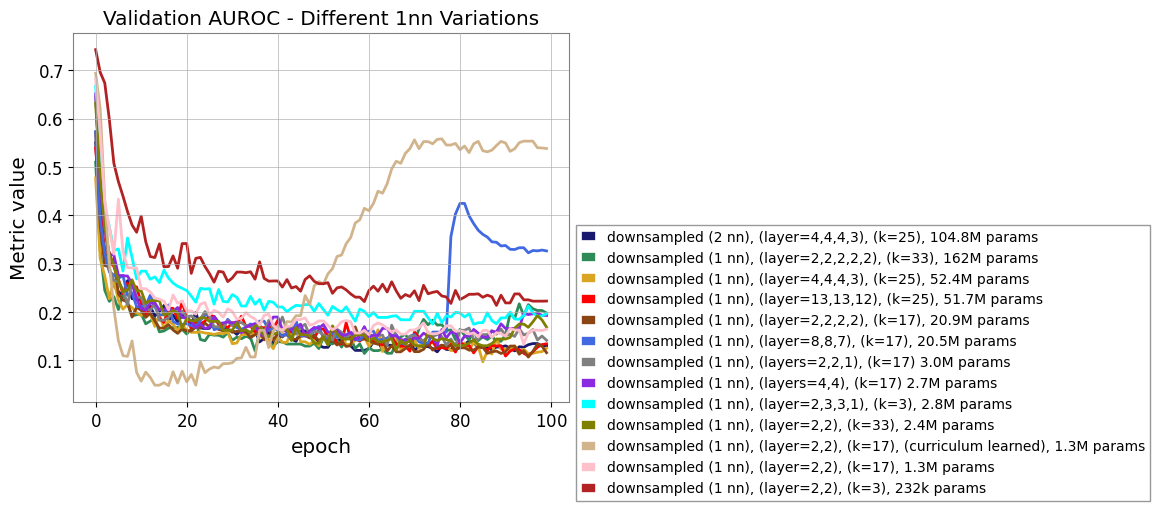

In [12]:
plt.plot(all_metrics[98]['train_epochs'], all_metrics[98]['train_loss'], linewidth=2, color = 'midnightblue', label="downsampled (2 nn), (layer=4,4,4,3), (k=25), 104.8M params")
# plt.plot(all_metrics[98]['valid_epochs'], all_metrics[98]['valid_loss'], linewidth=2, color = 'midnightblue', label="downsampled (2 nn), (layer=4,4,4,3), (k=25), 104.8M params")

plt.plot(all_metrics[78]['train_epochs'], all_metrics[78]['train_loss'], linewidth=2, color = 'seagreen', label="downsampled (1 nn), (layer=2,2,2,2,2), (k=33), 162M params")
# plt.plot(all_metrics[78]['valid_epochs'], all_metrics[78]['valid_loss'], linewidth=2, color = 'seagreen', label="downsampled (1 nn), (layer=2,2,2,2,2), (k=33), 162M params")

plt.plot(all_metrics[77]['train_epochs'], all_metrics[77]['train_loss'], linewidth=2, color = 'goldenrod', label="downsampled (1 nn), (layer=4,4,4,3), (k=25), 52.4M params")
# plt.plot(all_metrics[77]['valid_epochs'], all_metrics[77]['valid_loss'], linewidth=2, color = 'goldenrod', label="downsampled (1 nn), (layer=4,4,4,3), (k=25), 52.4M params")

plt.plot(all_metrics[76]['train_epochs'], all_metrics[76]['train_loss'], linewidth=2, color = 'red', label="downsampled (1 nn), (layer=13,13,12), (k=25), 51.7M params")
# plt.plot(all_metrics[76]['valid_epochs'], all_metrics[76]['valid_loss'], linewidth=2, color = 'red', label="downsampled (1 nn), (layer=13,13,12), (k=25), 51.7M params")

plt.plot(all_metrics[73]['train_epochs'], all_metrics[73]['train_loss'], linewidth=2, color = 'saddlebrown', label="downsampled (1 nn), (layer=2,2,2,2), (k=17), 20.9M params")
# plt.plot(all_metrics[73]['valid_epochs'], all_metrics[73]['valid_loss'], linewidth=2, color = 'saddlebrown', label="downsampled (1 nn), (layer=2,2,2,2), (k=17), 20.9M params")

plt.plot(all_metrics[72]['train_epochs'], all_metrics[72]['train_loss'], linewidth=2, color = 'royalblue', label="downsampled (1 nn), (layer=8,8,7), (k=17), 20.5M params")
# plt.plot(all_metrics[72]['valid_epochs'], all_metrics[72]['valid_loss'], linewidth=2, color = 'royalblue', label="downsampled (1 nn), (layer=8,8,7), (k=17), 20.5M params")

plt.plot(all_metrics[71]['train_epochs'], all_metrics[71]['train_loss'], linewidth=2, color = 'grey', label="downsampled (1 nn), (layers=2,2,1), (k=17) 3.0M params")
# plt.plot(all_metrics[71]['valid_epochs'], all_metrics[71]['valid_loss'], linewidth=2, color = 'grey', label="downsampled (1 nn), (layers=2,2,1), (k=17) 3.0M params")

plt.plot(all_metrics[70]['train_epochs'], all_metrics[70]['train_loss'], linewidth=2, color = 'blueviolet', label="downsampled (1 nn), (layers=4,4), (k=17) 2.7M params")
# plt.plot(all_metrics[70]['valid_epochs'], all_metrics[70]['valid_loss'], linewidth=2, color = 'blueviolet', label="downsampled (1 nn), (layers=4,4), (k=17) 2.7M params")

plt.plot(all_metrics[66]['train_epochs'], all_metrics[66]['train_loss'], linewidth=2, color = 'cyan', label="downsampled (1 nn), (layer=2,3,3,1), (k=3), 2.8M params")
# plt.plot(all_metrics[66]['valid_epochs'], all_metrics[66]['valid_loss'], linewidth=2, color = 'cyan', label="downsampled (1 nn), (layer=2,3,3,1), (k=3), 2.8M params")

plt.plot(all_metrics[62]['train_epochs'], all_metrics[62]['train_loss'], linewidth=2, color = 'olive', label="downsampled (1 nn), (layer=2,2), (k=33), 2.4M params")
# plt.plot(all_metrics[62]['valid_epochs'], all_metrics[62]['valid_loss'], linewidth=2, color = 'olive', label="downsampled (1 nn), (layer=2,2), (k=33), 2.4M params")

plt.plot(all_metric[63]['train_epochs'], all_metric[63]['train_loss'], linewidth=2, color = 'tan', label="downsampled (1 nn), (layer=2,2), (k=17), (curriculum learned), 1.3M params")
# plt.plot(all_metric[63]['valid_epochs'], all_metric[63]['valid_auroc'], linewidth=2, color = 'tan', label="downsampled (1 nn), (layer=2,2), (k=17), (curriculum learned), 1.3M params")

plt.plot(all_metrics[58]['train_epochs'], all_metrics[58]['train_loss'], linewidth=2, color = 'pink', label="downsampled (1 nn), (layer=2,2), (k=17), 1.3M params")
# plt.plot(all_metrics[58]['valid_epochs'], all_metrics[58]['valid_loss'], linewidth=2, color = 'pink', label="downsampled (1 nn), (layer=2,2), (k=17), 1.3M params")

plt.plot(all_metrics[52]['train_epochs'], all_metrics[52]['train_loss'], linewidth=2, color = 'firebrick', label="downsampled (1 nn), (layer=2,2), (k=3), 232k params")
# plt.plot(all_metrics[52]['valid_epochs'], all_metrics[52]['valid_loss'], linewidth=2, color = 'firebrick', label="downsampled (1 nn), (layer=2,2), (k=3), 232k params")

plt.title("Validation AUROC - Different 1nn Variations")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Metric value")
plt.legend(loc='best', fontsize='small', bbox_to_anchor=(1, 0.5))
plt.show()

## ROC Curve - false positive and true positive

In [13]:
def generate_batch(batch_size, background_dir=background_dir, seed=123, device=device):
    
    set_seed(seed)

    params = {k: v.sample((batch_size,)).to(device) for k, v in param_dict.items()}
    params["mass_1"], params["mass_2"] = chirp_mass_and_mass_ratio_to_components(
        params["chirp_mass"], params["mass_ratio"]
    )
    params["s1z"], params["s2z"] = params["chi1"], params["chi2"]

    hc, hp = waveform_generator(**params)

    dec = Sine()
    psi = Uniform(0, torch.pi)
    phi = Uniform(-torch.pi, torch.pi)
    responses = compute_observed_strain(
        dec=dec.sample((batch_size,)).to(device),
        psi=psi.sample((batch_size,)).to(device),
        phi=phi.sample((batch_size,)).to(device),
        detector_tensors=tensors,
        detector_vertices=vertices,
        sample_rate=sample_rate,
        cross=hc,
        plus=hp
    )

    spectral_density = SpectralDensity(
        sample_rate=sample_rate,
        fftlength=2,
        overlap=None,
        average="median"
    ).to(device)
    
    fnames = [list(background_dir.iterdir())[0]]
    with h5py.File(fnames[0], "r") as f:
        background = [torch.Tensor(f[ifo][:]) for ifo in ifos]
        background = torch.stack(background).to(device)
    
    psd = spectral_density(background.double())

    if psd.shape[-1] != num_freqs:
        while psd.ndim < 3:
            psd = psd[None]
        psd = torch.nn.functional.interpolate(
            psd, size=(num_freqs,), mode="linear"
        )

    target_snrs = Uniform(4, 100).sample((batch_size,)).to(device)

    responses = reweight_snrs(
        responses=responses,
        target_snrs=target_snrs,
        psd=psd,
        sample_rate=sample_rate,
        highpass=f_min
    )

    psd_size = int(psd_length * sample_rate)
    kernel_size = int(waveform_duration * sample_rate)
    window_length = psd_length + fduration + waveform_duration

    fnames = list(background_dir.iterdir())
    dataloader = Hdf5TimeSeriesDataset(
        fnames=fnames,
        channels=ifos,
        kernel_size=int(window_length * sample_rate),
        batch_size=2 * batch_size,
        batches_per_epoch=1,
        coincident=False,
    )

    background_samples = [x for x in dataloader][0].to(device)
    psd = spectral_density(background_samples[..., :psd_size].double())
    kernel = background_samples[..., psd_size:]

    pad = int(fduration / 2 * sample_rate)
    injected = kernel.detach().clone()
    injected[::2, :, pad:-pad] += responses[..., -kernel_size:]
    whitened = whiten(injected, psd)

    y = torch.zeros(len(injected))
    y[::2] = 1
    snr = torch.zeros(len(injected))
    snr[::2] = target_snrs

    return whitened.cpu(), y.cpu(), snr.cpu()

In [14]:
from tqdm import tqdm
import numpy as np

def run_inference(
    model,
    total_samples=1000,
    batch_size=200,
    seed=123,
    device=device,
    mode="single",
    variable_rate=False,
):
    
    n_batches = int(np.ceil(total_samples / batch_size))
    
    y_scores = []
    y_true = []
    snrs = []
    
    current_seed = seed
    model.eval()
    
    with torch.no_grad():
        for i in tqdm(range(n_batches), desc="Inference Batches"):
            
            X, y, snr = generate_batch(batch_size=batch_size, seed=current_seed, device=device)
            xb = X.to(device)
            
            if mode == "single" and not variable_rate:
                logits = model(xb) 

            elif mode == "single" and variable_rate:
                indices = model.build_variable_indices(sr=2048, device=device)
                xb = xb.index_select(dim=-1, index=indices)
                logits = model(xb)

            elif mode == "multi" and variable_rate:
                indices = model.build_variable_indices(sr=2048, device=device)
                xb = xb.index_select(dim=-1, index=indices)
                Xa, Xb, Xc = model.split_by_schedule(xb)
                logits = model(Xa, Xb, Xc)

            else:
                raise ValueError("Invalid combination")

            probs = torch.sigmoid(logits)
            
            y_scores.append(probs.cpu().numpy())
            y_true.append(y.numpy())
            snrs.append(snr.numpy())
            
            current_seed += 1

    y_scores = np.concatenate(y_scores, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    snrs = np.concatenate(snrs, axis=0)
    
    return y_scores, y_true, snrs

In [11]:
architecture = ResNet1D(in_channels=2, layers=[2, 2], classes=1, kernel_size=3,).to(device)

best_ckpt_path3 = "data/logs/ml4gw-expt/version_52/checkpoints/epoch=90-step=2366.ckpt"

model3 = Ml4gwDetectionModel.load_from_checkpoint(
    best_ckpt_path3,
    mode="single",
    variable_rate=True,
    attention=False,
    multimodla=False,
    architecture=architecture,
    metric=BinaryAUROC()
)

model3.eval()

y_score3, y_true3, snr_3 = run_inference(model=model3, total_samples=50000, batch_size=200, seed=123, device=device, mode="single", variable_rate=True)

fpr3, tpr3, thresholds3 = roc_curve(y_true3, y_score3)
roc_auc3 = auc(fpr3, tpr3)

Inference Batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [54:18<00:00, 13.04s/it]


In [11]:
architecture = ResNet1D(in_channels=2, layers=[2, 2], classes=1, kernel_size=17,).to(device)

best_ckpt_path4 = "data/logs/ml4gw-expt/version_58/checkpoints/epoch=92-step=2418.ckpt"

model4 = Ml4gwDetectionModel.load_from_checkpoint(
    best_ckpt_path4,
    mode="single",
    variable_rate=True,
    attention=False,
    multimodla=False,
    architecture=architecture,
    metric=BinaryAUROC()
)

model4.eval()

y_score4, y_true4, snr_4 = run_inference(model=model4, total_samples=50000, batch_size=200, seed=123, device=device, mode="single", variable_rate=True)

fpr4, tpr4, thresholds4 = roc_curve(y_true4, y_score4)
roc_auc4 = auc(fpr4, tpr4)

Inference Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [54:51<00:00, 13.16s/it]


In [17]:
architecture = ResNet1D(in_channels=2, layers=[2, 2], classes=1, kernel_size=17,).to(device)

best_ckpt_path11 = "data/logs/ml4gw-expt/version_63/checkpoints/epoch=83-step=2184.ckpt"

model11 = Ml4gwDetectionModel.load_from_checkpoint(
    best_ckpt_path11,
    mode="single",
    variable_rate=True,
    attention=False,
    multimodla=False,
    architecture=architecture,
    metric=BinaryAUROC()
)

model11.eval()

y_score11, y_true11, snr_11 = run_inference(model=model11, total_samples=50000, batch_size=200, seed=123, device=device, mode="single", variable_rate=True)

fpr11, tpr11, thresholds11 = roc_curve(y_true11, y_score11)
roc_auc11 = auc(fpr11, tpr11)

Inference Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [55:02<00:00, 13.21s/it]


In [11]:
architecture = ResNet1D(in_channels=2, layers=[2, 2], classes=1, kernel_size=33,).to(device)

best_ckpt_path12 = "data/logs/ml4gw-expt/version_62/checkpoints/epoch=84-step=2210.ckpt"

model12 = Ml4gwDetectionModel.load_from_checkpoint(
    best_ckpt_path12,
    mode="single",
    variable_rate=True,
    attention=False,
    multimodla=False,
    architecture=architecture,
    metric=BinaryAUROC()
)

model12.eval()

y_score12, y_true12, snr_12 = run_inference(model=model12, total_samples=50000, batch_size=200, seed=123, device=device, mode="single", variable_rate=True)

fpr12, tpr12, thresholds12 = roc_curve(y_true12, y_score12)
roc_auc12 = auc(fpr12, tpr12)

Inference Batches:   0%|                                                                                                                                                      | 0/250 [00:00<?, ?it/s]

Inference Batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [54:08<00:00, 12.99s/it]


In [12]:
snr_12[:10]

array([50.557186,  0.      , 33.7162  ,  0.      , 19.095129,
        0.      , 12.422239,  0.      , 65.42585 ,  0.      ],
      dtype=float32)

In [16]:
architecture = ResNet1D(in_channels=2, layers=[2, 3, 3, 1], classes=1, kernel_size=3,).to(device)

best_ckpt_path14 = "data/logs/ml4gw-expt/version_66/checkpoints/epoch=72-step=1898.ckpt"

model14 = Ml4gwDetectionModel.load_from_checkpoint(
    best_ckpt_path14,
    mode="single",
    variable_rate=True,
    attention=False,
    multimodla=False,
    architecture=architecture,
    metric=BinaryAUROC()
)

model14.eval()

y_score14, y_true14, snr_14 = run_inference(model=model14, total_samples=50000, batch_size=200, seed=123, device=device, mode="single", variable_rate=True)

fpr14, tpr14, thresholds14 = roc_curve(y_true14, y_score14)
roc_auc14 = auc(fpr14, tpr14)

Inference Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [54:08<00:00, 13.00s/it]


In [30]:
architecture = ResNet1D(in_channels=2, layers=[4, 4], classes=1, kernel_size=17,).to(device)

best_ckpt_path15 = "data/logs/ml4gw-expt/version_70/checkpoints/epoch=60-step=1586.ckpt"

model15 = Ml4gwDetectionModel.load_from_checkpoint(
    best_ckpt_path15,
    mode="single",
    variable_rate=True,
    attention=False,
    multimodla=False,
    architecture=architecture,
    metric=BinaryAUROC()
)

model15.eval()

y_score15, y_true15, snr_15 = run_inference(model=model15, total_samples=50000, batch_size=200, seed=123, device=device, mode="single", variable_rate=True)

fpr15, tpr15, thresholds15 = roc_curve(y_true15, y_score15)
roc_auc15 = auc(fpr15, tpr15)

Inference Batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [53:54<00:00, 12.94s/it]


In [34]:
architecture = ResNet1D(in_channels=2, layers=[2, 2, 1], classes=1, kernel_size=17,).to(device)

best_ckpt_path16 = "data/logs/ml4gw-expt/version_71/checkpoints/epoch=79-step=2080.ckpt"

model16 = Ml4gwDetectionModel.load_from_checkpoint(
    best_ckpt_path16,
    mode="single",
    variable_rate=True,
    attention=False,
    multimodla=False,
    architecture=architecture,
    metric=BinaryAUROC()
)

model16.eval()

y_score16, y_true16, snr_16 = run_inference(model=model16, total_samples=50000, batch_size=200, seed=123, device=device, mode="single", variable_rate=True)

fpr16, tpr16, thresholds16 = roc_curve(y_true16, y_score16)
roc_auc16 = auc(fpr16, tpr16)

Inference Batches:   2%|██▏                                                                                                                                    | 4/250 [00:50<52:00, 12.68s/it]

Inference Batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [52:47<00:00, 12.67s/it]


In [ ]:
architecture = ResNet1D(in_channels=2, layers=[8, 8, 7], classes=1, kernel_size=17,).to(device)

best_ckpt_path17 = "data/logs/ml4gw-expt/version_72/checkpoints/epoch=64-step=1690.ckpt"

model17 = Ml4gwDetectionModel.load_from_checkpoint(
    best_ckpt_path17,
    mode="single",
    variable_rate=True,
    attention=False,
    multimodal=False,
    architecture=architecture,
    metric=BinaryAUROC()
)

model17.eval()

y_score17, y_true17, snr_17 = run_inference(model=model17, total_samples=50000, batch_size=200, seed=123, device=device, mode="single", variable_rate=True)

fpr17, tpr17, thresholds17 = roc_curve(y_true17, y_score17)
roc_auc17 = auc(fpr17, tpr17)

Inference Batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [58:14<00:00, 13.98s/it]


In [15]:
architecture = ResNet1D(in_channels=2, layers=[2, 2, 2, 2], classes=1, kernel_size=17,).to(device)

best_ckpt_path18 = "data/logs/ml4gw-expt/version_73/checkpoints/epoch=66-step=1742.ckpt"

model18 = Ml4gwDetectionModel.load_from_checkpoint(
    best_ckpt_path18,
    mode="single",
    variable_rate=True,
    attention=False,
    multimodal=False,
    architecture=architecture,
    metric=BinaryAUROC()
)

model18.eval()

y_score18, y_true18, snr_18 = run_inference(model=model18, total_samples=50000, batch_size=200, seed=123, device=device, mode="single", variable_rate=True)

fpr18, tpr18, thresholds18 = roc_curve(y_true18, y_score18)
roc_auc18 = auc(fpr18, tpr18)

Inference Batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [57:10<00:00, 13.72s/it]


In [17]:
architecture = ResNet1D(in_channels=2, layers=[4, 4, 4, 3], classes=1, kernel_size=25,).to(device)

best_ckpt_path19 = "data/logs/ml4gw-expt/version_77/checkpoints/epoch=86-step=4176.ckpt"

model19 = Ml4gwDetectionModel.load_from_checkpoint(
    best_ckpt_path19,
    mode="single",
    variable_rate=True,
    attention=False,
    multimodal=False,
    architecture=architecture,
    metric=BinaryAUROC()
)

model19.eval()

y_score19, y_true19, snr_19 = run_inference(model=model19, total_samples=50000, batch_size=200, seed=123, device=device, mode="single", variable_rate=True)

fpr19, tpr19, thresholds19 = roc_curve(y_true19, y_score19)
roc_auc19 = auc(fpr19, tpr19)

Inference Batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [1:09:02<00:00, 16.57s/it]


In [22]:
architecture = ResNet1D(in_channels=2, layers=[13, 13, 12], classes=1, kernel_size=25,).to(device)

best_ckpt_path20 = "data/logs/ml4gw-expt/version_76/checkpoints/epoch=62-step=3024.ckpt"

model20 = Ml4gwDetectionModel.load_from_checkpoint(
    best_ckpt_path20,
    mode="single",
    variable_rate=True,
    attention=False,
    multimodal=False,
    architecture=architecture,
    metric=BinaryAUROC()
)

model20.eval()

y_score20, y_true20, snr_20 = run_inference(model=model20, total_samples=50000, batch_size=200, seed=123, device=device, mode="single", variable_rate=True)

fpr20, tpr20, thresholds20 = roc_curve(y_true20, y_score20)
roc_auc20 = auc(fpr20, tpr20)

Inference Batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [1:13:55<00:00, 17.74s/it]


In [18]:
architecture = ResNet1D(in_channels=2, layers=[2, 2, 2, 2, 2], classes=1, kernel_size=33,).to(device)

best_ckpt_path21 = "data/logs/ml4gw-expt/version_78/checkpoints/epoch=81-step=1066.ckpt"

model21 = Ml4gwDetectionModel.load_from_checkpoint(
    best_ckpt_path21,
    mode="single",
    variable_rate=True,
    attention=False,
    multimodal=False,
    architecture=architecture,
    metric=BinaryAUROC()
)

model21.eval()

y_score21, y_true21, snr_21 = run_inference(model=model21, total_samples=50000, batch_size=200, seed=123, device=device, mode="single", variable_rate=True)

fpr21, tpr21, thresholds21 = roc_curve(y_true21, y_score21)
roc_auc21 = auc(fpr21, tpr21)

Inference Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [1:11:52<00:00, 17.25s/it]


In [19]:
architecture_a = ResNet1D(in_channels=2, layers=[4, 4, 4, 3], classes=4, kernel_size=25,).to(device)
architecture_d = MLP(input_size=8, hidden_size=64, output_size=1).to(device)
architecture_i = ResNet1D(in_channels=4, layers=[4, 4, 4, 3], classes=4, kernel_size=25,).to(device)

best_ckpt_path22 = "data/logs/ml4gw-expt/version_98/checkpoints/epoch=87-step=4224.ckpt"

model22 = Ml4gwDetectionModel.load_from_checkpoint(
    best_ckpt_path22,
    mode="single",
    variable_rate=True,
    attention=False,
    multimodal=False,
    freq_series=True,
    architecture=architecture_a,
    architecture_d=architecture_d,
    architecture_i=architecture_i,
    metric=BinaryAUROC()
)

model22.eval()

y_score22, y_true22, snr_22 = run_inference(model=model22, total_samples=50000, batch_size=200, seed=123, device=device, mode="single", variable_rate=True)

fpr22, tpr22, thresholds22 = roc_curve(y_true22, y_score22)
roc_auc22 = auc(fpr22, tpr22)

Inference Batches: 100%|█████████████████████████████████| 250/250 [1:00:16<00:00, 14.47s/it]


In [15]:
import json 

with open("auroc_expts.json", "r") as f:
    rocdata = json.load(f)

fprs = [rocdata["version_52"]["fpr"], rocdata["version_58"]["fpr"], rocdata["version_63"]["fpr"], rocdata["version_62"]["fpr"], rocdata["version_66"]["fpr"], 
        rocdata["version_70"]["fpr"], rocdata["version_71"]["fpr"], rocdata["version_72"]["fpr"], rocdata["version_73"]["fpr"], rocdata["version_76"]["fpr"],
        rocdata["version_77"]["fpr"], rocdata["version_78"]["fpr"], rocdata["version_98"]["fpr"]]
tprs = [rocdata["version_52"]["tpr"], rocdata["version_58"]["tpr"], rocdata["version_63"]["tpr"], rocdata["version_62"]["tpr"], rocdata["version_66"]["tpr"],
        rocdata["version_70"]["tpr"], rocdata["version_71"]["tpr"], rocdata["version_72"]["tpr"], rocdata["version_73"]["tpr"], rocdata["version_76"]["tpr"],
        rocdata["version_77"]["tpr"], rocdata["version_78"]["tpr"], rocdata["version_98"]["tpr"]]
aucs = [rocdata["version_52"]["roc_auc"], rocdata["version_58"]["roc_auc"], rocdata["version_63"]["roc_auc"], rocdata["version_62"]["roc_auc"], rocdata["version_66"]["roc_auc"], 
        rocdata["version_70"]["roc_auc"], rocdata["version_71"]["roc_auc"], rocdata["version_72"]["roc_auc"], rocdata["version_73"]["roc_auc"], rocdata["version_76"]["roc_auc"],
        rocdata["version_77"]["roc_auc"], rocdata["version_78"]["roc_auc"], rocdata["version_98"]["roc_auc"]]
thresholds = [rocdata["version_52"]["threshold"], rocdata["version_58"]["threshold"], rocdata["version_63"]["threshold"], rocdata["version_62"]["threshold"], rocdata["version_66"]["threshold"], 
              rocdata["version_70"]["threshold"], rocdata["version_71"]["threshold"], rocdata["version_72"]["threshold"], rocdata["version_73"]["threshold"], rocdata["version_76"]["threshold"],
              rocdata["version_77"]["threshold"], rocdata["version_78"]["threshold"], rocdata["version_98"]["threshold"]]
y_score = [rocdata["version_52"]["yscore"], rocdata["version_58"]["yscore"], rocdata["version_63"]["yscore"], rocdata["version_62"]["yscore"], rocdata["version_66"]["yscore"], 
           rocdata["version_70"]["yscore"], rocdata["version_71"]["yscore"], rocdata["version_72"]["yscore"], rocdata["version_73"]["yscore"], rocdata["version_76"]["yscore"],
           rocdata["version_77"]["yscore"], rocdata["version_78"]["yscore"], rocdata["version_98"]["yscore"]]
snrs = rocdata["version_52"]["snr"]
y_true = rocdata["version_52"]["ytrue"]

In [21]:
rocdata["version_98"] = {
    "fpr": fpr22.tolist(),
    "tpr": tpr22.tolist(),
    "roc_auc": float(roc_auc22),   
    "threshold": thresholds22.tolist(),
    "yscore": y_score22.tolist(),
    "ytrue": y_true22.tolist(),
    "snr": snr_22.tolist(),
}

with open("auroc_expts.json", "w") as f:
    json.dump(rocdata, f, indent=4)

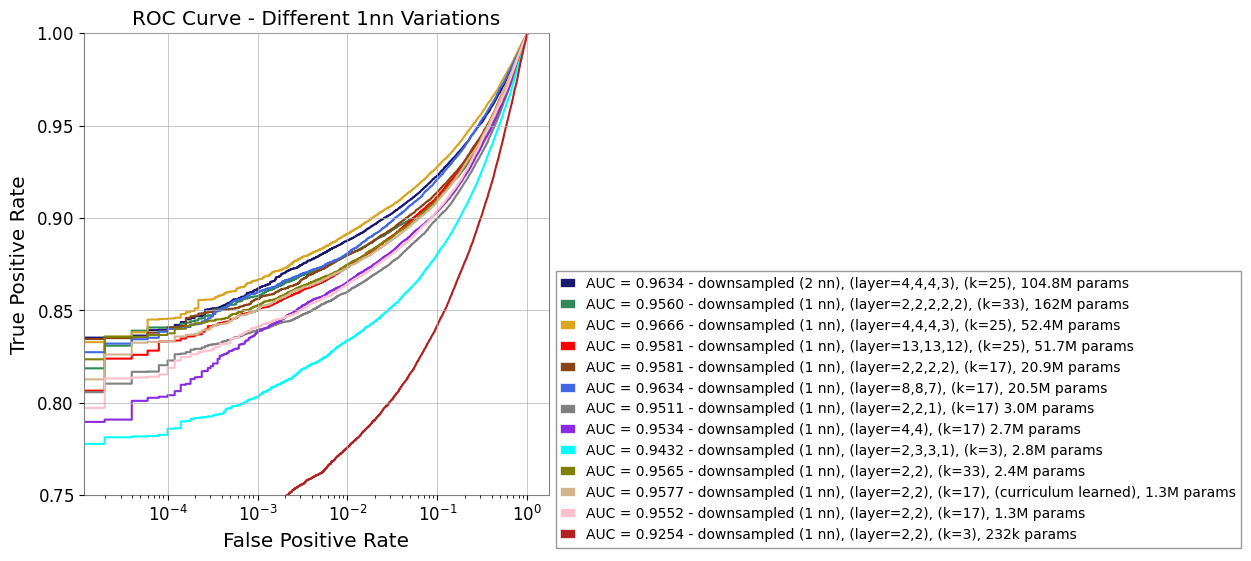

In [16]:
plt.figure(figsize=(6,6))

plt.plot(fprs[12], tprs[12], color = 'midnightblue', label=f"AUC = {aucs[12]:.4f} - downsampled (2 nn), (layer=4,4,4,3), (k=25), 104.8M params")
plt.plot(fprs[11], tprs[11], color = 'seagreen', label=f"AUC = {aucs[11]:.4f} - downsampled (1 nn), (layer=2,2,2,2,2), (k=33), 162M params")
plt.plot(fprs[10], tprs[10], color = 'goldenrod', label=f"AUC = {aucs[10]:.4f} - downsampled (1 nn), (layer=4,4,4,3), (k=25), 52.4M params")
plt.plot(fprs[9], tprs[9], color = 'red', label=f"AUC = {aucs[9]:.4f} - downsampled (1 nn), (layer=13,13,12), (k=25), 51.7M params")
plt.plot(fprs[8], tprs[8], color = 'saddlebrown', label=f"AUC = {aucs[8]:.4f} - downsampled (1 nn), (layer=2,2,2,2), (k=17), 20.9M params")
plt.plot(fprs[7], tprs[7], color = 'royalblue', label=f"AUC = {aucs[7]:.4f} - downsampled (1 nn), (layer=8,8,7), (k=17), 20.5M params")
plt.plot(fprs[6], tprs[6], color = 'grey', label=f"AUC = {aucs[6]:.4f} - downsampled (1 nn), (layer=2,2,1), (k=17) 3.0M params")
plt.plot(fprs[5], tprs[5], color = 'blueviolet', label=f"AUC = {aucs[5]:.4f} - downsampled (1 nn), (layer=4,4), (k=17) 2.7M params")
plt.plot(fprs[4], tprs[4], color = 'cyan', label=f"AUC = {aucs[4]:.4f} - downsampled (1 nn), (layer=2,3,3,1), (k=3), 2.8M params")
plt.plot(fprs[3], tprs[3], color = 'olive', label=f"AUC = {aucs[3]:.4f} - downsampled (1 nn), (layer=2,2), (k=33), 2.4M params")
plt.plot(fprs[2], tprs[2], color = 'tan', label=f"AUC = {aucs[2]:.4f} - downsampled (1 nn), (layer=2,2), (k=17), (curriculum learned), 1.3M params")
plt.plot(fprs[1], tprs[1], color = 'pink', label=f"AUC = {aucs[1]:.4f} - downsampled (1 nn), (layer=2,2), (k=17), 1.3M params")
plt.plot(fprs[0], tprs[0], color = 'firebrick', label=f"AUC = {aucs[0]:.4f} - downsampled (1 nn), (layer=2,2), (k=3), 232k params")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Different 1nn Variations")
plt.legend(loc='best', fontsize='small', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.xscale('log')
# plt.gca().invert_xaxis()
# plt.xlim(0.4, 1)
plt.ylim(0.75, 1)
plt.show()

In [17]:
import numpy as np

def compute_efficiency(
    s_snr, 
    s_score, 
    fpr, 
    thresholds, 
    target_fpr=0.1, 
    bin_start=8, 
    bin_stop=102, 
    bin_step=2
):

    bins = np.arange(bin_start, bin_stop, bin_step)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    idx = np.argmin(np.abs(fpr - target_fpr))
    threshold = thresholds[idx]

    efficiencies = []
    errors = []
    for i in range(len(bins) - 1):
        in_bin = (s_snr >= bins[i]) & (s_snr < bins[i + 1])
        if np.sum(in_bin) == 0:
            efficiencies.append(np.nan) 
            errors.append(np.nan)
            continue
        detected = np.sum(s_score[in_bin] > threshold)
        eff = detected / np.sum(in_bin)
        err = ((eff)*(1-eff)/np.sum(in_bin))**(1/2)

        efficiencies.append(eff)
        errors.append(err)

    return bin_centers, np.array(efficiencies), np.array(errors)

In [18]:
y_score = [np.array(ys) for ys in y_score]
fprs = [np.array(fs) for fs in fprs]
thresholds = [np.array(ts) for ts in thresholds]
snrs = np.array(snrs)
y_true = np.array(y_true)

s = y_true == 1
s_snr = snrs[s]

s_score0 = y_score[0][s]
s_score1 = y_score[1][s]
s_score2 = y_score[2][s]
s_score3 = y_score[3][s]
s_score4 = y_score[4][s]
s_score5 = y_score[5][s]
s_score6 = y_score[6][s]
s_score7 = y_score[7][s]
s_score8 = y_score[8][s]
s_score9 = y_score[9][s]
s_score10 = y_score[10][s]
s_score11 = y_score[11][s]
s_score12 = y_score[12][s]

In [19]:
bin_centers, efficiencies00, errors00 = compute_efficiency(s_snr, s_score0, fprs[0], thresholds[0], target_fpr=0.001, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies01, errors01 = compute_efficiency(s_snr, s_score0, fprs[0], thresholds[0], target_fpr=0.1, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies02, errors02 = compute_efficiency(s_snr, s_score0, fprs[0], thresholds[0], target_fpr=0.2, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies03, errors03 = compute_efficiency(s_snr, s_score0, fprs[0], thresholds[0], target_fpr=0.5, bin_start=8, bin_stop=102, bin_step=2)


bin_centers, efficiencies10, errors10 = compute_efficiency(s_snr, s_score1, fprs[1], thresholds[1], target_fpr=0.001, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies11, errors11 = compute_efficiency(s_snr, s_score1, fprs[1], thresholds[1], target_fpr=0.1, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies12, errors12 = compute_efficiency(s_snr, s_score1, fprs[1], thresholds[1], target_fpr=0.2, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies13, errors13 = compute_efficiency(s_snr, s_score1, fprs[1], thresholds[1], target_fpr=0.5, bin_start=8, bin_stop=102, bin_step=2)


bin_centers, efficiencies20, errors20 = compute_efficiency(s_snr, s_score2, fprs[2], thresholds[2], target_fpr=0.001, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies21, errors21 = compute_efficiency(s_snr, s_score2, fprs[2], thresholds[2], target_fpr=0.1, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies22, errors22 = compute_efficiency(s_snr, s_score2, fprs[2], thresholds[2], target_fpr=0.2, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies23, errors23 = compute_efficiency(s_snr, s_score2, fprs[2], thresholds[2], target_fpr=0.5, bin_start=8, bin_stop=102, bin_step=2)


bin_centers, efficiencies30, errors30 = compute_efficiency(s_snr, s_score3, fprs[3], thresholds[3], target_fpr=0.001, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies31, errors31 = compute_efficiency(s_snr, s_score3, fprs[3], thresholds[3], target_fpr=0.1, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies32, errors32 = compute_efficiency(s_snr, s_score3, fprs[3], thresholds[3], target_fpr=0.2, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies33, errors33 = compute_efficiency(s_snr, s_score3, fprs[3], thresholds[3], target_fpr=0.5, bin_start=8, bin_stop=102, bin_step=2)


bin_centers, efficiencies40, errors40 = compute_efficiency(s_snr, s_score4, fprs[4], thresholds[4], target_fpr=0.001, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies41, errors41 = compute_efficiency(s_snr, s_score4, fprs[4], thresholds[4], target_fpr=0.1, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies42, errors42 = compute_efficiency(s_snr, s_score4, fprs[4], thresholds[4], target_fpr=0.2, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies43, errors43 = compute_efficiency(s_snr, s_score4, fprs[4], thresholds[4], target_fpr=0.5, bin_start=8, bin_stop=102, bin_step=2)


bin_centers, efficiencies50, errors50 = compute_efficiency(s_snr, s_score5, fprs[5], thresholds[5], target_fpr=0.001, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies51, errors51 = compute_efficiency(s_snr, s_score5, fprs[5], thresholds[5], target_fpr=0.1, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies52, errors52 = compute_efficiency(s_snr, s_score5, fprs[5], thresholds[5], target_fpr=0.2, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies53, errors53 = compute_efficiency(s_snr, s_score5, fprs[5], thresholds[5], target_fpr=0.5, bin_start=8, bin_stop=102, bin_step=2)


bin_centers, efficiencies60, errors60 = compute_efficiency(s_snr, s_score6, fprs[6], thresholds[6], target_fpr=0.001, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies61, errors61 = compute_efficiency(s_snr, s_score6, fprs[6], thresholds[6], target_fpr=0.1, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies62, errors62 = compute_efficiency(s_snr, s_score6, fprs[6], thresholds[6], target_fpr=0.2, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies63, errors63 = compute_efficiency(s_snr, s_score6, fprs[6], thresholds[6], target_fpr=0.5, bin_start=8, bin_stop=102, bin_step=2)


bin_centers, efficiencies70, errors70 = compute_efficiency(s_snr, s_score7, fprs[7], thresholds[7], target_fpr=0.001, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies71, errors71 = compute_efficiency(s_snr, s_score7, fprs[7], thresholds[7], target_fpr=0.1, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies72, errors72 = compute_efficiency(s_snr, s_score7, fprs[7], thresholds[7], target_fpr=0.2, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies73, errors73 = compute_efficiency(s_snr, s_score7, fprs[7], thresholds[7], target_fpr=0.5, bin_start=8, bin_stop=102, bin_step=2)


bin_centers, efficiencies80, errors80 = compute_efficiency(s_snr, s_score8, fprs[8], thresholds[8], target_fpr=0.001, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies81, errors81 = compute_efficiency(s_snr, s_score8, fprs[8], thresholds[8], target_fpr=0.1, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies82, errors82 = compute_efficiency(s_snr, s_score8, fprs[8], thresholds[8], target_fpr=0.2, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies83, errors83 = compute_efficiency(s_snr, s_score8, fprs[8], thresholds[8], target_fpr=0.5, bin_start=8, bin_stop=102, bin_step=2)

bin_centers, efficiencies90, errors90 = compute_efficiency(s_snr, s_score9, fprs[9], thresholds[9], target_fpr=0.001, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies91, errors91 = compute_efficiency(s_snr, s_score9, fprs[9], thresholds[9], target_fpr=0.1, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies92, errors92 = compute_efficiency(s_snr, s_score9, fprs[9], thresholds[9], target_fpr=0.2, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies93, errors93 = compute_efficiency(s_snr, s_score9, fprs[9], thresholds[9], target_fpr=0.5, bin_start=8, bin_stop=102, bin_step=2)

bin_centers, efficiencies100, errors100 = compute_efficiency(s_snr, s_score10, fprs[10], thresholds[10], target_fpr=0.001, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies101, errors101 = compute_efficiency(s_snr, s_score10, fprs[10], thresholds[10], target_fpr=0.1, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies102, errors102 = compute_efficiency(s_snr, s_score10, fprs[10], thresholds[10], target_fpr=0.2, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies103, errors103 = compute_efficiency(s_snr, s_score10, fprs[10], thresholds[10], target_fpr=0.5, bin_start=8, bin_stop=102, bin_step=2)

bin_centers, efficiencies110, errors110 = compute_efficiency(s_snr, s_score11, fprs[11], thresholds[11], target_fpr=0.001, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies111, errors111 = compute_efficiency(s_snr, s_score11, fprs[11], thresholds[11], target_fpr=0.1, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies112, errors112 = compute_efficiency(s_snr, s_score11, fprs[11], thresholds[11], target_fpr=0.2, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies113, errors113 = compute_efficiency(s_snr, s_score11, fprs[11], thresholds[11], target_fpr=0.5, bin_start=8, bin_stop=102, bin_step=2)

bin_centers, efficiencies120, errors120 = compute_efficiency(s_snr, s_score12, fprs[12], thresholds[12], target_fpr=0.001, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies121, errors121 = compute_efficiency(s_snr, s_score12, fprs[12], thresholds[12], target_fpr=0.1, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies122, errors122 = compute_efficiency(s_snr, s_score12, fprs[12], thresholds[12], target_fpr=0.2, bin_start=8, bin_stop=102, bin_step=2)
_, efficiencies123, errors123 = compute_efficiency(s_snr, s_score12, fprs[12], thresholds[12], target_fpr=0.5, bin_start=8, bin_stop=102, bin_step=2)

/home/bhgupta/.conda/envs/mlgw/lib/python3.10/site-packages/gwpy/plot/axes.py:82: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  return func(self, **kw)


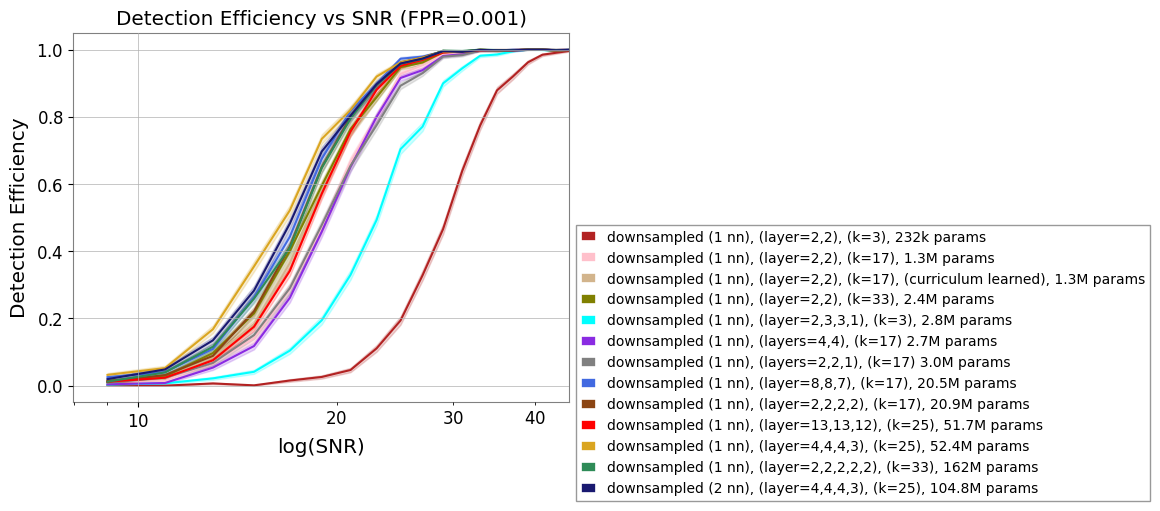

In [20]:
# plt.figure(figsize=(6,6))

plt.plot(bin_centers, efficiencies00, color='firebrick', label='downsampled (1 nn), (layer=2,2), (k=3), 232k params')
plt.fill_between(bin_centers, efficiencies00 - errors00, efficiencies00 + errors00, color='firebrick', alpha=0.2)
# plt.plot(bin_centers, efficiencies01, color='firebrick', label='downsampled (1 nn), (layer=2,2), (k=3), 232k params')
# plt.fill_between(bin_centers, efficiencies01 - errors01, efficiencies01 + errors01, color='firebrick', alpha=0.2)
# plt.plot(bin_centers, efficiencies02, color='firebrick', label='downsampled (1 nn), (layer=2,2), (k=3), 232k params')
# plt.fill_between(bin_centers, efficiencies02 - errors02, efficiencies02 + errors02, color='firebrick', alpha=0.2)
# plt.plot(bin_centers, efficiencies03, color='firebrick', label='downsampled (1 nn), (layer=2,2), (k=3), 232k params')
# plt.fill_between(bin_centers, efficiencies03 - errors03, efficiencies03 + errors03, color='firebrick', alpha=0.2)

plt.plot(bin_centers, efficiencies10, color='pink', label='downsampled (1 nn), (layer=2,2), (k=17), 1.3M params')
plt.fill_between(bin_centers, efficiencies10 - errors10, efficiencies10 + errors10, color='pink', alpha=0.4)
# plt.plot(bin_centers, efficiencies11, color='pink', label='downsampled (1 nn), (layer=2,2), (k=17), 1.3M params')
# plt.fill_between(bin_centers, efficiencies11 - errors11, efficiencies11 + errors11, color='pink', alpha=0.4)
# plt.plot(bin_centers, efficiencies12, color='pink', label='downsampled (1 nn), (layer=2,2), (k=17), 1.3M params')
# plt.fill_between(bin_centers, efficiencies12 - errors12, efficiencies12 + errors12, color='pink', alpha=0.4)
# plt.plot(bin_centers, efficiencies13, color='pink', label='downsampled (1 nn), (layer=2,2), (k=17), 1.3M params')
# plt.fill_between(bin_centers, efficiencies13 - errors13, efficiencies13 + errors13, color='pink', alpha=0.4)

plt.plot(bin_centers, efficiencies20, color='tan', label='downsampled (1 nn), (layer=2,2), (k=17), (curriculum learned), 1.3M params')
plt.fill_between(bin_centers, efficiencies20 - errors20, efficiencies20 + errors20, color='tan', alpha=0.4)
# plt.plot(bin_centers, efficiencies21, color='tan', label='downsampled (1 nn), (layer=2,2), (k=17), (curriculum learned), 1.3M params')
# plt.fill_between(bin_centers, efficiencies21 - errors21, efficiencies21 + errors21, color='tan', alpha=0.4)
# plt.plot(bin_centers, efficiencies22, color='tan', label='downsampled (1 nn), (layer=2,2), (k=17), (curriculum learned), 1.3M params')
# plt.fill_between(bin_centers, efficiencies22 - errors22, efficiencies22 + errors22, color='tan', alpha=0.4)
# plt.plot(bin_centers, efficiencies23, color='tan', label='downsampled (1 nn), (layer=2,2), (k=17), (curriculum learned), 1.3M params')
# plt.fill_between(bin_centers, efficiencies23 - errors23, efficiencies23 + errors23, color='tan', alpha=0.4)

plt.plot(bin_centers, efficiencies30, color='olive', label='downsampled (1 nn), (layer=2,2), (k=33), 2.4M params')
plt.fill_between(bin_centers, efficiencies30 - errors30, efficiencies30 + errors30, color='olive', alpha=0.2)
# plt.plot(bin_centers, efficiencies31, color='olive', label='downsampled (1 nn), (layer=2,2), (k=33), 2.4M params')
# plt.fill_between(bin_centers, efficiencies31 - errors31, efficiencies31 + errors31, color='olive', alpha=0.2)
# plt.plot(bin_centers, efficiencies32, color='olive', label='downsampled (1 nn), (layer=2,2), (k=33), 2.4M params')
# plt.fill_between(bin_centers, efficiencies32 - errors32, efficiencies32 + errors32, color='olive', alpha=0.2)
# plt.plot(bin_centers, efficiencies33, color='olive', label='downsampled (1 nn), (layer=2,2), (k=33), 2.4M params')
# plt.fill_between(bin_centers, efficiencies33 - errors33, efficiencies33 + errors33, color='olive', alpha=0.2)

plt.plot(bin_centers, efficiencies40, color='cyan', label='downsampled (1 nn), (layer=2,3,3,1), (k=3), 2.8M params')
plt.fill_between(bin_centers, efficiencies40 - errors40, efficiencies40 + errors40, color='cyan', alpha=0.2)
# plt.plot(bin_centers, efficiencies41, color='cyan', label='downsampled (1 nn), (layer=2,3,3,1), (k=3), 2.8M params')
# plt.fill_between(bin_centers, efficiencies41 - errors41, efficiencies41 + errors41, color='cyan', alpha=0.2)
# plt.plot(bin_centers, efficiencies42, color='cyan', label='downsampled (1 nn), (layer=2,3,3,1), (k=3), 2.8M params')
# plt.fill_between(bin_centers, efficiencies42 - errors42, efficiencies42 + errors42, color='cyan', alpha=0.2)
# plt.plot(bin_centers, efficiencies43, color='cyan', label='downsampled (1 nn), (layer=2,3,3,1), (k=3), 2.8M params')
# plt.fill_between(bin_centers, efficiencies43 - errors43, efficiencies43 + errors43, color='cyan', alpha=0.2)

plt.plot(bin_centers, efficiencies50, color='blueviolet', label='downsampled (1 nn), (layers=4,4), (k=17) 2.7M params')
plt.fill_between(bin_centers, efficiencies50 - errors50, efficiencies50 + errors50, color='blueviolet', alpha=0.2)
# plt.plot(bin_centers, efficiencies51, color='blueviolet', label='downsampled (1 nn), (layers=4,4), (k=17) 2.7M params')
# plt.fill_between(bin_centers, efficiencies51 - errors51, efficiencies51 + errors51, color='blueviolet', alpha=0.2)
# plt.plot(bin_centers, efficiencies52, color='blueviolet', label='downsampled (1 nn), (layers=4,4), (k=17) 2.7M params')
# plt.fill_between(bin_centers, efficiencies52 - errors50, efficiencies52 + errors52, color='blueviolet', alpha=0.2)
# plt.plot(bin_centers, efficiencies53, color='blueviolet', label='downsampled (1 nn), (layers=4,4), (k=17) 2.7M params')
# plt.fill_between(bin_centers, efficiencies53 - errors53, efficiencies53 + errors53, color='blueviolet', alpha=0.2)

plt.plot(bin_centers, efficiencies60, color='grey', label='downsampled (1 nn), (layers=2,2,1), (k=17) 3.0M params')
plt.fill_between(bin_centers, efficiencies60 - errors60, efficiencies60 + errors60, color='grey', alpha=0.2)
# plt.plot(bin_centers, efficiencies61, color='grey', label='downsampled (1 nn), (layers=2,2,1), (k=17) 3.0M params')
# plt.fill_between(bin_centers, efficiencies61 - errors61, efficiencies61 + errors61, color='grey', alpha=0.2)
# plt.plot(bin_centers, efficiencies62, color='grey', label='downsampled (1 nn), (layers=2,2,1), (k=17) 3.0M params')
# plt.fill_between(bin_centers, efficiencies62 - errors62, efficiencies62 + errors62, color='grey', alpha=0.2)
# plt.plot(bin_centers, efficiencies63, color='grey', label='downsampled (1 nn), (layers=2,2,1), (k=17) 3.0M params')
# plt.fill_between(bin_centers, efficiencies63 - errors63, efficiencies63 + errors63, color='grey', alpha=0.2)

plt.plot(bin_centers, efficiencies70, color='royalblue', label='downsampled (1 nn), (layer=8,8,7), (k=17), 20.5M params')
plt.fill_between(bin_centers, efficiencies70 - errors70, efficiencies70 + errors70, color='royalblue', alpha=0.2)
# plt.plot(bin_centers, efficiencies71, color='royalblue', label='downsampled (1 nn), (layer=8,8,7), (k=17), 20.5M params')
# plt.fill_between(bin_centers, efficiencies71 - errors71, efficiencies71 + errors71, color='royalblue', alpha=0.2)
# plt.plot(bin_centers, efficiencies72, color='royalblue', label='downsampled (1 nn), (layer=8,8,7), (k=17), 20.5M params')
# plt.fill_between(bin_centers, efficiencies72 - errors72, efficiencies72 + errors72, color='royalblue', alpha=0.2)
# plt.plot(bin_centers, efficiencies73, color='royalblue', label='downsampled (1 nn), (layer=8,8,7), (k=17), 20.5M params')
# plt.fill_between(bin_centers, efficiencies73 - errors73, efficiencies73 + errors73, color='royalblue', alpha=0.2)

plt.plot(bin_centers, efficiencies80, color='saddlebrown', label='downsampled (1 nn), (layer=2,2,2,2), (k=17), 20.9M params')
plt.fill_between(bin_centers, efficiencies80 - errors80, efficiencies80 + errors80, color='saddlebrown', alpha=0.2)
# plt.plot(bin_centers, efficiencies81, color='saddlebrown', label='downsampled (1 nn), (layer=2,2,2,2), (k=17), 20.9M params')
# plt.fill_between(bin_centers, efficiencies81 - errors81, efficiencies81 + errors81, color='saddlebrown', alpha=0.2)
# plt.plot(bin_centers, efficiencies82, color='saddlebrown', label='downsampled (1 nn), (layer=2,2,2,2), (k=17), 20.9M params')
# plt.fill_between(bin_centers, efficiencies82 - errors82, efficiencies82 + errors82, color='saddlebrown', alpha=0.2)
# plt.plot(bin_centers, efficiencies83, color='saddlebrown', label='downsampled (1 nn), (layer=2,2,2,2), (k=17), 20.9M params')
# plt.fill_between(bin_centers, efficiencies83 - errors83, efficiencies83 + errors83, color='saddlebrown', alpha=0.2)

plt.plot(bin_centers, efficiencies90, color='red', label='downsampled (1 nn), (layer=13,13,12), (k=25), 51.7M params')
plt.fill_between(bin_centers, efficiencies90 - errors90, efficiencies90 + errors90, color='red', alpha=0.2)
# plt.plot(bin_centers, efficiencies91, color='red', label='downsampled (1 nn), (layer=13,13,12), (k=25), 51.7M params')
# plt.fill_between(bin_centers, efficiencies91 - errors91, efficiencies91 + errors91, color='red', alpha=0.2)
# plt.plot(bin_centers, efficiencies92, color='red', label='downsampled (1 nn), (layer=13,13,12), (k=25), 51.7M params')
# plt.fill_between(bin_centers, efficiencies92 - errors92, efficiencies92 + errors92, color='red', alpha=0.2)
# plt.plot(bin_centers, efficiencies93, color='red', label='downsampled (1 nn), (layer=13,13,12), (k=25), 51.7M params')
# plt.fill_between(bin_centers, efficiencies93 - errors93, efficiencies93 + errors93, color='red', alpha=0.2)

plt.plot(bin_centers, efficiencies100, color='goldenrod', label='downsampled (1 nn), (layer=4,4,4,3), (k=25), 52.4M params')
plt.fill_between(bin_centers, efficiencies100 - errors100, efficiencies100 + errors100, color='goldenrod', alpha=0.2)
# plt.plot(bin_centers, efficiencies101, color='goldenrod', label='downsampled (1 nn), (layer=4,4,4,3), (k=25), 52.4M params')
# plt.fill_between(bin_centers, efficiencies101 - errors101, efficiencies101 + errors101, color='goldenrod', alpha=0.2)
# plt.plot(bin_centers, efficiencies102, color='goldenrod', label='downsampled (1 nn), (layer=4,4,4,3), (k=25), 52.4M params')
# plt.fill_between(bin_centers, efficiencies102 - errors102, efficiencies102 + errors102, color='goldenrod', alpha=0.2)
# plt.plot(bin_centers, efficiencies103, color='goldenrod', label='downsampled (1 nn), (layer=4,4,4,3), (k=25), 52.4M params')
# plt.fill_between(bin_centers, efficiencies103 - errors103, efficiencies103 + errors103, color='goldenrod', alpha=0.2)

plt.plot(bin_centers, efficiencies110, color='seagreen', label='downsampled (1 nn), (layer=2,2,2,2,2), (k=33), 162M params')
plt.fill_between(bin_centers, efficiencies110 - errors110, efficiencies110 + errors110, color='seagreen', alpha=0.2)
# plt.plot(bin_centers, efficiencies111, color='seagreen', label='downsampled (1 nn), (layer=2,2,2,2,2), (k=33), 162M params')
# plt.fill_between(bin_centers, efficiencies111 - errors111, efficiencies111 + errors111, color='seagreen', alpha=0.2)
# plt.plot(bin_centers, efficiencies112, color='seagreen', label='downsampled (1 nn), (layer=2,2,2,2,2), (k=33), 162M params')
# plt.fill_between(bin_centers, efficiencies112 - errors112, efficiencies112 + errors112, color='seagreen', alpha=0.2)
# plt.plot(bin_centers, efficiencies113, color='seagreen', label='downsampled (1 nn), (layer=2,2,2,2,2), (k=33), 162M params')
# plt.fill_between(bin_centers, efficiencies113 - errors113, efficiencies113 + errors113, color='seagreen', alpha=0.2)

plt.plot(bin_centers, efficiencies120, color='midnightblue', label='downsampled (2 nn), (layer=4,4,4,3), (k=25), 104.8M params')
plt.fill_between(bin_centers, efficiencies120 - errors120, efficiencies120 + errors120, color='midnightblue', alpha=0.2)
# plt.plot(bin_centers, efficiencies121, color='midnightblue', label='downsampled (2 nn), (layer=4,4,4,3), (k=25), 104.8M params')
# plt.fill_between(bin_centers, efficiencies121 - errors121, efficiencies121 + errors121, color='midnightblue', alpha=0.2)
# plt.plot(bin_centers, efficiencies122, color='midnightblue', label='downsampled (2 nn), (layer=4,4,4,3), (k=25), 104.8M params')
# plt.fill_between(bin_centers, efficiencies122 - errors122, efficiencies122 + errors122, color='midnightblue', alpha=0.2)
# plt.plot(bin_centers, efficiencies123, color='midnightblue', label='downsampled (2 nn), (layer=4,4,4,3), (k=25), 104.8M params')
# plt.fill_between(bin_centers, efficiencies123 - errors123, efficiencies123 + errors123, color='midnightblue', alpha=0.2)



plt.xlabel("log(SNR)")
plt.ylabel("Detection Efficiency")
plt.legend(loc='best', fontsize='small', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.xlim(0,45)
plt.title("Detection Efficiency vs SNR (FPR=0.001)")
plt.show()

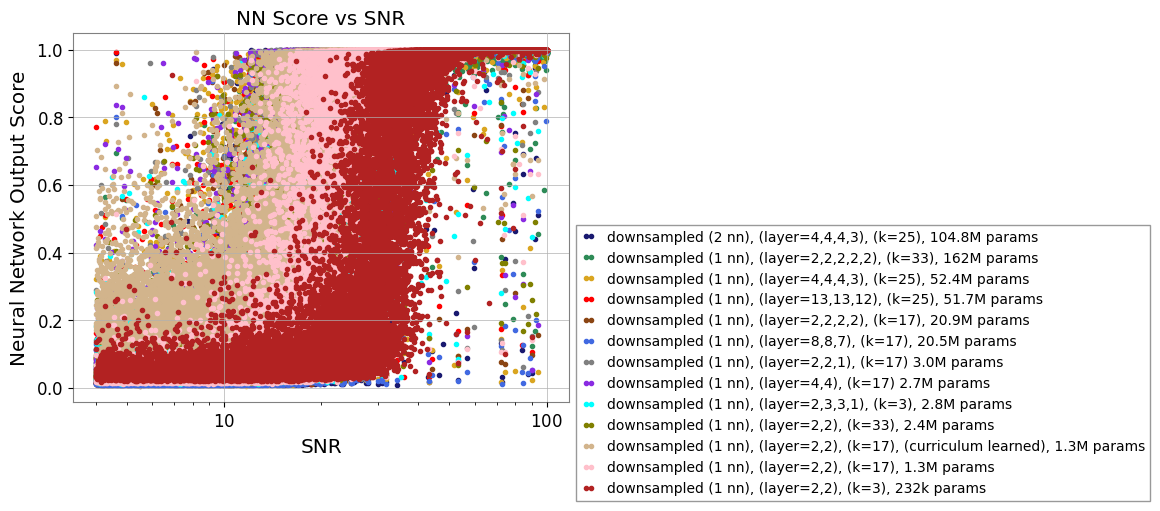

In [ ]:
plt.plot(s_snr, s_score12, '.', color = 'midnightblue', label="downsampled (2 nn), (layer=4,4,4,3), (k=25), 104.8M params")
plt.plot(s_snr, s_score11, '.', color = 'seagreen', label="downsampled (1 nn), (layer=2,2,2,2,2), (k=33), 162M params")
plt.plot(s_snr, s_score10, '.', color = 'goldenrod', label="downsampled (1 nn), (layer=4,4,4,3), (k=25), 52.4M params")
plt.plot(s_snr, s_score9, '.', color = 'red', label="downsampled (1 nn), (layer=13,13,12), (k=25), 51.7M params")
plt.plot(s_snr, s_score8, '.', color = 'saddlebrown', label="downsampled (1 nn), (layer=2,2,2,2), (k=17), 20.9M params")
plt.plot(s_snr, s_score7, '.', color = 'royalblue', label="downsampled (1 nn), (layer=8,8,7), (k=17), 20.5M params")
plt.plot(s_snr, s_score6, '.', color = 'grey', label="downsampled (1 nn), (layer=2,2,1), (k=17) 3.0M params")
plt.plot(s_snr, s_score5, '.', color = 'blueviolet', label="downsampled (1 nn), (layer=4,4), (k=17) 2.7M params")
plt.plot(s_snr, s_score4, '.', color = 'cyan', label="downsampled (1 nn), (layer=2,3,3,1), (k=3), 2.8M params")
plt.plot(s_snr, s_score3, '.', color = 'olive', label="downsampled (1 nn), (layer=2,2), (k=33), 2.4M params")
plt.plot(s_snr, s_score2, '.', color = 'tan', label="downsampled (1 nn), (layer=2,2), (k=17), (curriculum learned), 1.3M params")
plt.plot(s_snr, s_score1, '.', color = 'pink', label="downsampled (1 nn), (layer=2,2), (k=17), 1.3M params")
plt.plot(s_snr, s_score0, '.', color = 'firebrick', label="downsampled (1 nn), (layer=2,2), (k=3), 232k params")

plt.xlabel("SNR")
plt.ylabel("Neural Network Output Score")
plt.title("NN Score vs SNR")
plt.legend(loc='best', fontsize='small', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.xscale('log')